In [72]:
import pandas as pd

# Load your data
df = pd.read_csv("../data/data.csv")
df.columns



Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'],
      dtype='object')

In [73]:
new_column_names = {
    'Age': 'age',
    'Gender': 'gender',
    'Weight (kg)': 'weight_kg',
    'Height (m)': 'height_m',
    'Max_BPM': 'max_bpm',
    'Avg_BPM': 'avg_bpm',
    'Resting_BPM': 'resting_bpm',
    'Session_Duration (hours)': 'session_duration_hours',
    'Calories_Burned': 'calories_burned',
    'Workout_Type': 'workout_type',
    'Fat_Percentage': 'fat_percentage',
    'Water_Intake (liters)': 'water_intake_liters',
    'Workout_Frequency (days/week)': 'workout_frequency_per_week',
    'Experience_Level': 'experience_level',
    'BMI': 'bmi'
}
df.rename(columns=new_column_names, inplace=True)


In [74]:
df.columns

Index(['age', 'gender', 'weight_kg', 'height_m', 'max_bpm', 'avg_bpm',
       'resting_bpm', 'session_duration_hours', 'calories_burned',
       'workout_type', 'fat_percentage', 'water_intake_liters',
       'workout_frequency_per_week', 'experience_level', 'bmi'],
      dtype='object')

In [96]:
import itertools
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import numpy as np

# Candidate features (removed 'workout_type' because it's the target)
candidate_features = [
    'age', 'gender', 'weight_kg', 'height_m', 'max_bpm', 'avg_bpm',
    'resting_bpm', 'session_duration_hours', 'calories_burned',
    'fat_percentage', 'water_intake_liters',
    'workout_frequency_per_week', 'experience_level', 'bmi'
]

# Prepare data
X = df[candidate_features].copy()

# Encode categorical features BEFORE train/test split
# Example: 'gender' and 'experience_level' might be categorical
for col in ['gender', 'experience_level']:
    if col in X.columns and X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

# Encode target variable 'workout_type'
le_target = LabelEncoder()
y = le_target.fit_transform(df['workout_type'])

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)

best_score = 0
best_features = None

min_features = 3
max_features = 6

for subset_size in range(min_features, max_features + 1):
    for subset in itertools.combinations(candidate_features, subset_size):
        # Select subset features
        X_train_sub = X_train[list(subset)]
        X_test_sub = X_test[list(subset)]

        # Scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_sub)
        X_test_scaled = scaler.transform(X_test_sub)

        # Apply SMOTE only on training data
        X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

        # Prepare LightGBM datasets
        lgb_train = lgb.Dataset(X_train_res, label=y_train_res)
        lgb_eval = lgb.Dataset(X_test_scaled, label=y_test, reference=lgb_train)

        params = {
            'objective': 'multiclass',
            'num_class': len(le_target.classes_),
            'metric': 'multi_logloss',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': 7,
            'verbose': -1,
            'seed': 42
        }

        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=100,
            valid_sets=[lgb_eval],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=0)  # silent
            ]
        )

        # Predict and evaluate
        y_pred = model.predict(X_test_scaled)
        y_pred_labels = np.argmax(y_pred, axis=1)

        acc = accuracy_score(y_test, y_pred_labels)

        if acc > best_score:
            best_score = acc
            best_features = subset
            print(f"New best accuracy: {best_score:.4f} with features: {best_features}")

print(f"\nBest feature subset: {best_features}")
print(f"Best test accuracy: {best_score:.4f}")




Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.38724
New best accuracy: 0.2410 with features: ('age', 'gender', 'weight_kg')
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.38873
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	valid_0's multi_logloss: 1.38352
New best accuracy: 0.2769 with features: ('age', 'gender', 'max_bpm')
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.38688
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_logloss: 1.3857
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.38652
Training until validation scores don't improve for 10 rounds


Univariate feature scores (ANOVA F-test):
fat_percentage                1.894962
session_duration_hours        1.582679
experience_level_3            1.193372
bmi                           1.059866
height_m                      1.048456
workout_frequency_per_week    1.034652
calories_burned               0.949043
age                           0.825395
max_bpm                       0.817258
weight_kg                     0.813012
resting_bpm                   0.765075
experience_level_2            0.650946
gender_Male                   0.465847
water_intake_liters           0.396692
avg_bpm                       0.248183
dtype: float64


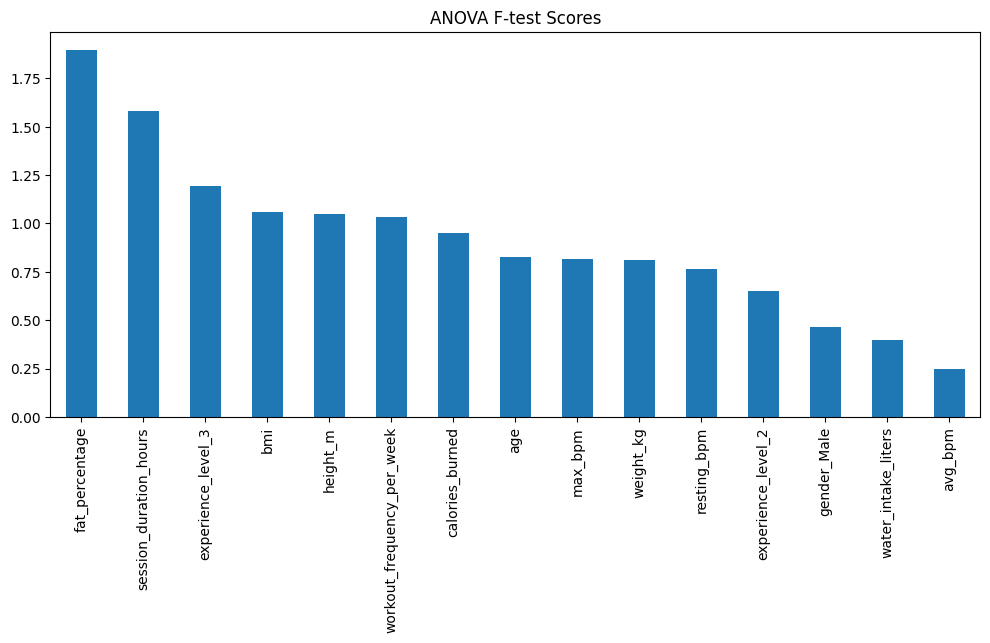


Random Forest Feature Importances:
calories_burned               0.095375
bmi                           0.093401
weight_kg                     0.093176
fat_percentage                0.091849
max_bpm                       0.088024
avg_bpm                       0.087826
session_duration_hours        0.087790
age                           0.085655
height_m                      0.081468
resting_bpm                   0.076731
water_intake_liters           0.062065
workout_frequency_per_week    0.029540
experience_level_2            0.013399
gender_Male                   0.010204
experience_level_3            0.003500
dtype: float64


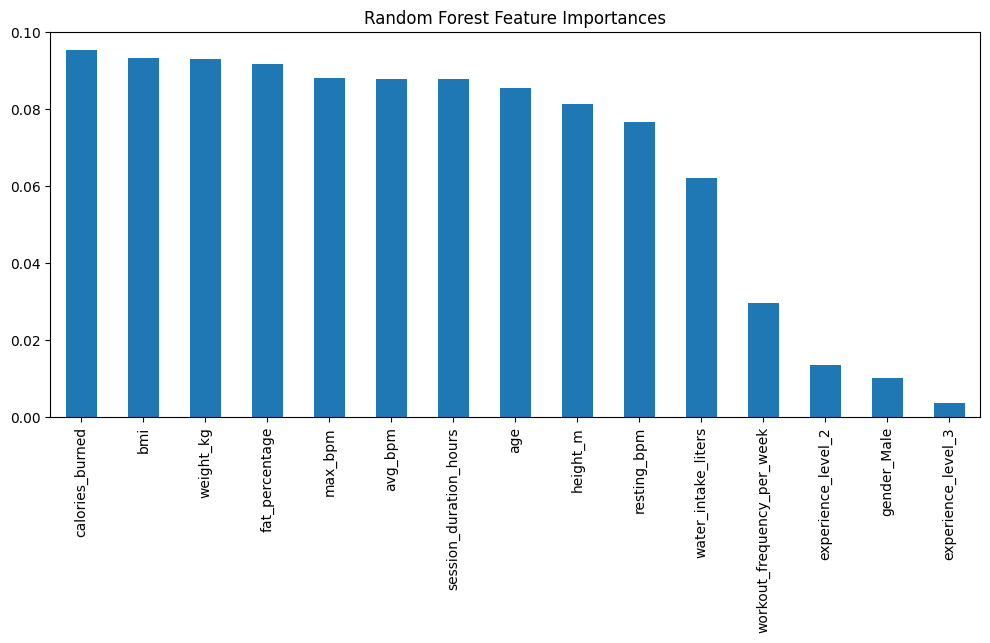

c:\Users\yine6\OneDrive\Bureau\ml project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\yine6\OneDrive\Bureau\ml project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin


RFE Selected Features (Logistic Regression):
['height_m', 'session_duration_hours', 'water_intake_liters', 'gender_Male', 'experience_level_3']


c:\Users\yine6\OneDrive\Bureau\ml project\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
# Features and target
features = [
    'age', 'gender', 'weight_kg', 'height_m', 'max_bpm', 'avg_bpm',
    'resting_bpm', 'session_duration_hours', 'calories_burned',
    'fat_percentage', 'water_intake_liters', 'workout_frequency_per_week',
    'experience_level', 'bmi'
]

X = df[features]
y = df['workout_type']

# Encode categorical variables
X = pd.get_dummies(X, columns=['gender', 'experience_level'], drop_first=True)

# 1) Univariate feature selection (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
scores = selector.scores_

anova_features = pd.Series(scores, index=X.columns).sort_values(ascending=False)
print("Univariate feature scores (ANOVA F-test):")
print(anova_features)

# Plot ANOVA scores
anova_features.plot(kind='bar', figsize=(12,5), title='ANOVA F-test Scores')
plt.show()

# 2) Random Forest feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandom Forest Feature Importances:")
print(rf_importances)

# Plot RF importances
rf_importances.plot(kind='bar', figsize=(12,5), title='Random Forest Feature Importances')
plt.show()

# 3) Recursive Feature Elimination (RFE) with Logistic Regression
logreg = LogisticRegression(max_iter=500, random_state=42)
rfe = RFE(logreg, n_features_to_select=5)
rfe.fit(X, y)

rfe_features = pd.Series(rfe.support_, index=X.columns)
print("\nRFE Selected Features (Logistic Regression):")
print(rfe_features[rfe_features == True].index.tolist())




In [87]:
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Features and target
features = [
    'calories_burned', 'bmi', 'weight_kg', 'fat_percentage', 'max_bpm',
    'avg_bpm', 'session_duration_hours', 'age', 'height_m', 'resting_bpm'
]

X = df[features]
le = LabelEncoder()
y = le.fit_transform(df['workout_type'])

# Split dataset with stratify to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance classes on training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Prepare LightGBM datasets
lgb_train = lgb.Dataset(X_train_resampled, y_train_resampled)
lgb_eval = lgb.Dataset(X_test_scaled, y_test, reference=lgb_train)

# LightGBM parameters
params = {
    'objective': 'multiclass',
    'num_class': len(le.classes_),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 7,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

# Train model with early stopping callback
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

# Predict probabilities
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Convert probabilities to class labels
y_train_pred_labels = y_train_pred.argmax(axis=1)
y_test_pred_labels = y_test_pred.argmax(axis=1)

# Print training results
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_labels))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred_labels, target_names=le.classes_))

# Print testing results
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred_labels))
print("Testing Classification Report:\n", classification_report(y_test, y_test_pred_labels, target_names=le.classes_))




Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.36982	valid_1's multi_logloss: 1.3898
Training Accuracy: 0.4305912596401028
Training Classification Report:
               precision    recall  f1-score   support

      Cardio       0.45      0.43      0.44       204
        HIIT       0.41      0.38      0.39       177
    Strength       0.43      0.39      0.41       206
        Yoga       0.43      0.52      0.47       191

    accuracy                           0.43       778
   macro avg       0.43      0.43      0.43       778
weighted avg       0.43      0.43      0.43       778

Testing Accuracy: 0.2205128205128205
Testing Classification Report:
               precision    recall  f1-score   support

      Cardio       0.23      0.24      0.23        51
        HIIT       0.29      0.25      0.27        44
    Strength       0.20      0.19      0.20        52
        Yoga       0.18      0.21      0.1

In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from collections import Counter

# Assume you already have your DataFrame: df



# Selected features
selected_features = [
 'weight_kg', 'height_m', 'calories_burned', 'fat_percentage', 'bmi'
]

# Prepare X and y
X = df[selected_features]
y = df['workout_type']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Compute class weights
counter = Counter(y_train)
total = sum(counter.values())
class_weights = {cls: total / (len(counter) * count) for cls, count in counter.items()}
sample_weights = y_train.map(class_weights)

# Define the model
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42
)

# Define hyperparameter grid
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.5, 1, 2]
}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

# Fit with sample weights
search.fit(X_train, y_train, sample_weight=sample_weights)

# Best estimator
best_model = search.best_estimator_

# Predict
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluation
class_names = [str(c) for c in le.inverse_transform(np.unique(y))]
print("Best Parameters:", search.best_params_)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Training Classification Report:\n", classification_report(y_train, y_train_pred, target_names=class_names))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("Testing Classification Report:\n", classification_report(y_test, y_test_pred, target_names=class_names))"""


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Training Accuracy: 0.9947596263385737
Training Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2147
           1       1.00      0.99      0.99      3035
           2       0.99      1.00      1.00      1674
           3       0.99      1.00      1.00      1922

    accuracy                           0.99      8778
   macro avg       0.99      1.00      1.00      8778
weighted avg       0.99      0.99      0.99      8778

Testing Accuracy: 0.2697038724373576
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.21      0.22       537
           1       0.35      0.41      0.38       759
           2       0.19      0.16 

              
""""""

 





































 
















In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
# Encode target variable
le = LabelEncoder()
df['Workout_Type_Encoded'] = le.fit_transform(df['Workout_Type'])

# Prepare features and target
X = df.drop(columns=['Workout_Type', 'Workout_Type_Encoded', 'Calories_Burned'])
y = df['Workout_Type_Encoded']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Gender', 'Experience_Level'], drop_first=True)

# RFE with Random Forest
clf = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=clf, n_features_to_select=5)
rfe.fit(X, y)

print("RFE selected features:", X.columns[rfe.support_].tolist())



RFE selected features: ['Weight (kg)', 'Max_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'BMI']


In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier




# Prepare features and target
X = df.drop(columns=['Workout_Type', 'Workout_Type_Encoded', 'Calories_Burned'])
y = df['Workout_Type_Encoded']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Gender', 'Experience_Level'], drop_first=True)

# Train Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

importances = clf.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

print("Top features by Random Forest importance:\n", feat_importance.head(5))


Top features by Random Forest importance:
 Fat_Percentage              0.107043
Session_Duration (hours)    0.105223
BMI                         0.101982
Weight (kg)                 0.099604
Max_BPM                     0.096199
dtype: float64


In [ ]:
"""import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder





# Selected features from RFE
selected_features = ['Weight (kg)', 'Max_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'BMI']

X = df[selected_features]
y = df['Workout_Type_Encoded']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest Classifier
model = RandomForestClassifier(random_state=42)

# Train model
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate train set
train_acc = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_acc)
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))

# Evaluate test set
test_acc = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_acc)
print("Testing Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix for test
print("Testing Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# Cross-validation (5-fold)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validated Accuracy (5 folds): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")"""


Training Accuracy: 1.0
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       1.00      1.00      1.00       177
           2       1.00      1.00      1.00       206
           3       1.00      1.00      1.00       191

    accuracy                           1.00       778
   macro avg       1.00      1.00      1.00       778
weighted avg       1.00      1.00      1.00       778

Testing Accuracy: 0.2358974358974359
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.24      0.24        51
           1       0.25      0.20      0.23        44
           2       0.26      0.31      0.28        52
           3       0.18      0.19      0.18        48

    accuracy                           0.24       195
   macro avg       0.24      0.23      0.23       195
weighted avg       0.24      0.24      0.23       195

Testi

In [ ]:
"""import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder



# Encode categorical variables
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])  # Male=1, Female=0 (example)
df['Experience_Level'] = LabelEncoder().fit_transform(df['Experience_Level'])
df['Workout_Type_Encoded'] = le.fit_transform(df['Workout_Type'])
# Features to use (existing top + suggested extras)
selected_features = [
    'Fat_Percentage', 'Session_Duration (hours)', 'BMI', 'Weight (kg)', 'Max_BPM',
    'Age', 'Gender', 'Experience_Level', 'Workout_Frequency (days/week)', 'Water_Intake (liters)'
]

X = df[selected_features]
y = df['Workout_Type_Encoded']  # Make sure this column exists

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Training evaluation
y_train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Testing evaluation
y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

# Cross-validation accuracy on full data with best model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Feature importances
importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)

# Output results
print("Best hyperparameters:", grid_search.best_params_)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Cross-validated Accuracy (5 folds): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n")
print("Feature Importances:\n", importances)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))"""


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 200}
Training Accuracy: 0.9576
Testing Accuracy: 0.1949
Cross-validated Accuracy (5 folds): 0.2415 ± 0.0281

Feature Importances:
 BMI                              0.150782
Weight (kg)                      0.147800
Fat_Percentage                   0.144884
Session_Duration (hours)         0.138866
Age                              0.129298
Max_BPM                          0.128251
Water_Intake (liters)            0.093529
Workout_Frequency (days/week)    0.033702
Experience_Level                 0.020276
Gender                           0.012612
dtype: float64

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.21      0.22      0.21        51
           1       0.18      0.14      0.16        44
           2       0.18      0.19      0.19        52
           3       0.20      0.23      0.22        48

    accuracy                           0.19       

In [ ]:
"""from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute balanced class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', GradientBoostingClassifier(random_state=42))
])

# Train
pipeline.fit(X_train, y_train)

# Evaluate
print("Training Accuracy:", pipeline.score(X_train, y_train))
print("Testing Accuracy:", pipeline.score(X_test, y_test))"""


Training Accuracy: 0.8650385604113111
Testing Accuracy: 0.2205128205128205


In [21]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Replace X, y with your dataset
# X, y = ...

# 1. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Balance training data with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 4. Define model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 5. Hyperparameter space
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 9, None],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# 6. Randomized Search (no early stopping here)
search = RandomizedSearchCV(
    xgb_model, param_dist, n_iter=30, scoring='accuracy', cv=5,
    random_state=42, n_jobs=-1, verbose=1
)

search.fit(X_train_bal, y_train_bal)

print("Best hyperparameters:", search.best_params_)
print(f"Best CV accuracy: {search.best_score_:.4f}")

# 7. Train best model WITHOUT early stopping
best_model = search.best_estimator_
best_model.fit(X_train_bal, y_train_bal)

# 8. Predict
y_train_pred = best_model.predict(X_train_bal)
y_test_pred = best_model.predict(X_test_scaled)

# 9. Evaluate
print("\n--- Training Performance ---")
print(f"Training accuracy: {accuracy_score(y_train_bal, y_train_pred):.4f}")
print(classification_report(y_train_bal, y_train_pred))

print("\n--- Testing Performance ---")
print(f"Testing accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\yine6\OneDrive\Bureau\ml project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:26:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best CV accuracy: 0.3387

--- Training Performance ---
Training accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       1.00      1.00      1.00       206
           2       1.00      1.00      1.00       206
           3       1.00      1.00      1.00       206

    accuracy                           1.00       824
   macro avg       1.00      1.00      1.00       824
weighted avg       1.00      1.00      1.00       824


--- Testing Performance ---
Testing accuracy: 0.2308
              precision    recall  f1-score   support

           0       0.26      0.27      0.27        51
           1       0.20      0.18      0.19        44
           2       0.20      0.19      0.20        52
           3       0.25      0.27      0.26        48

    accuracy                     